In [4]:
import os
import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt

from tensorflow_datasets import testing
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Agarramos todos los sonidos y los convertimos en mfcc
#Cargamos nuestro conjunto de datos

ds_path ='/content/drive/MyDrive/ColabNotebooks/genres_original'

# #Funcion que agarra un numero de audios para luego convertirlos a MFCC (Mel-frequency cepstral coefficient)

def audioMFCC(audio):
  audio_series , sample_rate = librosa.load(audio,duration = 30.0,res_type="soxr_hq")
  mfcc = librosa.feature.mfcc(y=audio_series, sr=sample_rate, n_mfcc=40).T
  #np.ndarray [shape=(…, n_mfcc, t)]
  return mfcc,audio_series

datasetMFCC = []
labelsMFCC = []

# Obtener lista de géneros desde las carpetas
GENRE_CLASSES = sorted(os.listdir(ds_path))
#De la carpeta recorremos todos los elemento de ds_path para procesarlos y guardarlos en nuuestro vector

# Recorrer cada género y sus archivos
for label_index, genre in enumerate(GENRE_CLASSES):
    genre_path = os.path.join(ds_path, genre)

    if not os.path.isdir(genre_path):
        continue  # Ignorar archivos sueltos

    print(f"Procesando género: {genre}")
    for file in os.listdir(genre_path):
        if file.endswith(".wav"):
            file_path = os.path.join(genre_path, file)

            try:
                # Cargar el audio y convertirlo a MFCC
                y = file_path
                mfcc,audio_series = audioMFCC(file_path)

                # Si el audio es muy corto, lo ignoramos
                if len(audio_series) < 2048:
                    print(f"Audio muy corto, saltando: {file_path}")
                    continue


                datasetMFCC.append(mfcc)
                labelsMFCC.append(label_index)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ColabNotebooks/genres_original'

Cantidad de MFCC: 999
Cantidad de etiquetas: 999
Tamaño de un MFCC: (1292, 40)


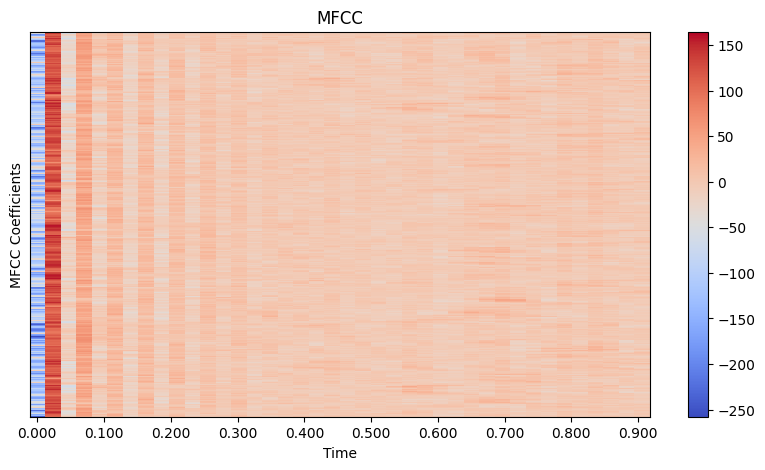

In [ ]:
print("Cantidad de MFCC:", len(datasetMFCC))
print("Cantidad de etiquetas:", len(labelsMFCC))
print("Tamaño de un MFCC:", datasetMFCC[0].shape)
plt.figure(figsize=(10, 5))
librosa.display.specshow(datasetMFCC[0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.xlabel('Time')
plt.ylabel('MFCC Coefficients')
plt.show()

In [ ]:
def pad_mfcc(mfcc, max_len=1300):
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        return np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')
    else:
        return mfcc[:max_len]

# Aplicar padding a todos
X = np.array([pad_mfcc(mfcc) for mfcc in datasetMFCC])#, dtype=np.float32)
y = np.array(labelsMFCC, dtype=np.int32)
# División 80% entrenamiento, 20% validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Cantidad de MFCC para entrenamiento:", len(X_train))
print("Cantidad de MFCC para validación:", len(X_val))
BATCH_SIZE = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Cantidad de MFCC para entrenamiento: 799
Cantidad de MFCC para validación: 200


In [ ]:
# Crear modelo
def genreClassifier(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

input_shape = X_train.shape[1:]  # (1300, 40)

model = genreClassifier(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(train_ds, validation_data=val_ds, epochs=30)

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

def plot_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.

    Args:
        history: The History object returned by model.fit().
    """

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Subplot 1: Accuracy
    plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Precisión del Modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True) # Add a grid for better readability

    # Subplot 2: Loss
    plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Pérdida del Modelo')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend()
    plt.grid(True) # Add a grid for better readability

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

test_loss, test_acc = model.evaluate(val_ds)
print('Test accuracy:', test_acc)

model.save("genre_classifier_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 1300, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1300, 64)       │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,714 (252.79 KB)

 Trainable params: 64,714 (252.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.0991 - loss: 2.3147 - val_accuracy: 0.1000 - val_loss: 2.3102
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.1246 - loss: 2.2794 - val_accuracy: 0.1150 - val_loss: 2.2865
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.1732 - loss: 2.2480 - val_accuracy: 0.1900 - val_loss: 2.2624
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2049 - loss: 2.2249 - val_accuracy: 0.2200 - val_loss: 2.2363
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1933 - loss: 2.2041 - val_accuracy: 0.2500 - val_loss: 2.2109
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2302 - loss: 2.1788 - val_accuracy: 0.2750 - val_loss: 2.1813
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3012 - loss: 2.1113 - val_accuracy: 0.2800 - val_loss: 2.1471
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2829 - loss: 2.0906 - val_accuracy: 0.2750 - val_loss:

Test accuracy: 0.41499999165534973


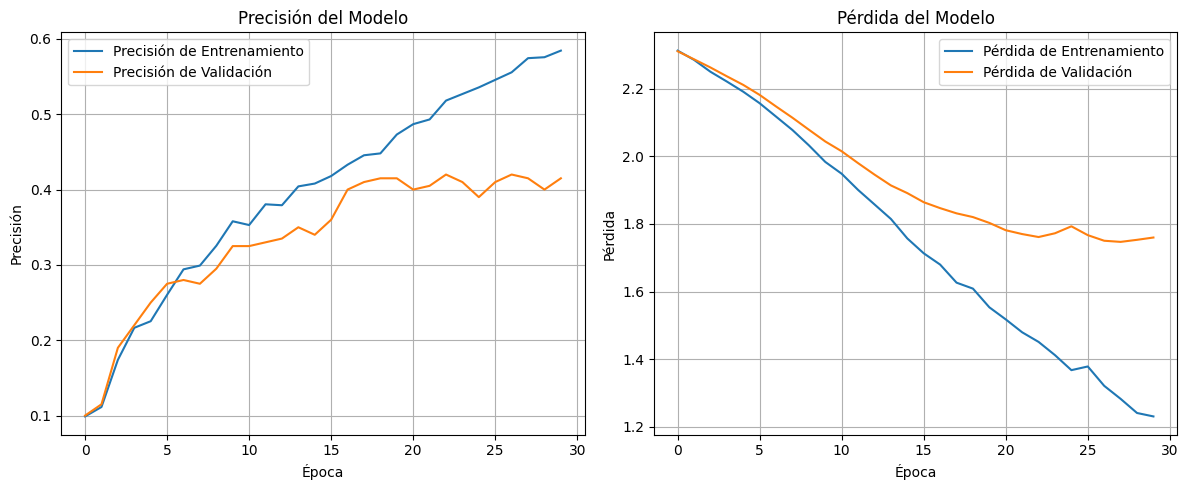

In [ ]:
plot_history(history)